<a href="https://colab.research.google.com/github/christopher-hsu/latent-map-planning/blob/master/siameseCVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Shared by all
import os
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils # We should use this eventually.
from torch import nn, optim
from torch.nn import functional as F
import numpy as np


# For DataLoader
from PIL import Image
import numbers

import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Dataset Code: `CarlaDataset.py`

In [0]:

class CarlaDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        # xcxc I'm assuming that the images live in _out.
        self.data_dir = data_dir
        self.transform = transform
        self.df = self._get_dataframe()
        self.df_as_mat = self.df.values
    
    def __len__(self):
        num_rows, _ = self.df_as_mat.shape
        return num_rows
    
    def __getitem__(self, idx):
        '''
        Generate one sample of data.
        '''
        # We're gonna do some hardcore hard-coding here.
        # First, extract our control inputs
        row = self.df_as_mat[idx, :]
        # xcxc We're... We're not exactly doing anything with our control inputs. For now.
        # We lop off the final value in -1 because of our dataframe- we 
        # interpret the indicator value of whether it's stationary or not 
        # as a boolean, and python interprets it as a number.
        control_inputs = np.array(
            [x for x in row if isinstance(x, numbers.Number)][:-1])
        is_stationary = row[-1]
        
        curr_images = self._get_image_tensor_for_row(row[0], is_stationary)
        # Get the next row
        next_delta = 4 # xcxc This is a hardcoded parameter from Klayton's data.
        next_input_id = int(row[0]) + next_delta
        num_rows_next = np.sum(self.df['input_num'] == str(next_input_id))
        if num_rows_next == 0:
            # No next: treat it as if we're stationary
            return (curr_images, curr_images, np.zeros(len(control_inputs)))
        elif is_stationary == True:
            # If it's stationary, then simply return our current images
            return (curr_images, curr_images, np.zeros(len(control_inputs)))
        else:
            next_images = self._get_image_tensor_for_row(
                str(next_input_id), is_stationary)
            return (curr_images, next_images, control_inputs)
    
    def _get_image_tensor_for_row(self, row_id, is_stationary):
        '''
        Inputs:
            row_id: String that represents the input_num
        Outputs:
            A (2 x H x W x 4) 4D matrix of the two images.
        '''
        # The row_id should be the input_num. Should also be a string.
        which_row = (self.df['input_num'] == row_id)
        where_stationary = (self.df['is_stationary'] == is_stationary)
        row = self.df[which_row & where_stationary]
        n_res, _ = row.shape
        if n_res > 1:
            # xcxc I'm assuming there's only one row per row_id.
            # This may or may not be a strictly held invariant.
            print("XCXC: THERE ARE MORE THAN 1 ROW FOR A ROW_ID")
        row = row.values[0]
        images = []
        for ele in row:
            if str(ele).split('.')[-1] == 'png':
                full_name = os.path.join(self.data_dir, '_out', ele)
                np_arr = np.asarray(Image.open(full_name))
                np_arr = self._rearrange_axes_image(np_arr)
                # Apply transform on each image independently.
                if self.transform:
                    np_arr = self.transform(np_arr)
                images.append(np_arr)
        images = np.array(images)
        return images
    
    def _rearrange_axes_image(self, img):
        H,W,_ = img.shape
        new_img = np.zeros((3,H,W))
        for i in range(3):
            new_img[i,:,:] = img[:,:,i]
        return new_img

    def _get_dataframe(self):
        control_input_df = self._get_control_input_df()
        filename_df = self._get_image_path_df()
        df = control_input_df.merge(right=filename_df,
                                    left_on='input_num',
                                    right_on='index')
        # Then, we add a column to our dataframe saying whether it's stationary or not
        num_rows, _ = df.shape
        df['is_stationary'] = np.zeros((num_rows), dtype=bool)
        # Then make a copy and set is_stationary to true...
        df_copy = df.copy()
        df_copy['is_stationary'] = np.ones((num_rows), dtype=bool)
        # then stack and return
        final_df = pd.concat([df, df_copy])
        return final_df

    def _get_control_input_df(self):
        # xcxc I'm also assuming that our columns in control_input stay static like so.
        control_input_df = pd.read_csv(os.path.join(self.data_dir, 'control_input.txt'),
                               names=['input_num', 'ctr1', 'ctr2'])
        control_input_df['input_num'] = control_input_df['input_num'].astype('str')
        return control_input_df
    
    def _get_image_path_df(self):
        # A little cryptic, but it just gets the list of all filenames
        all_files_in_out = [x[2] for x in os.walk(os.path.join(self.data_dir, '_out'))][0]
        # Then filter out by getting only the png files. We can remove this step if need be.
        all_files_in_out = [img_name for img_name in all_files_in_out if img_name.split('.')[1] == 'png']

        # We can then make a map with our data...
        filename_groupings = {}
        for fn in all_files_in_out:
            fn_number = str(int(fn.split('_')[0]))
            if fn_number not in filename_groupings:
                filename_groupings[fn_number] = []
            filename_groupings[fn_number].append(fn)
            
        # Then make a dataframe from this dictionary
        filename_df = pd.DataFrame.from_dict(
            filename_groupings, orient='index').reset_index()
        filename_df = filename_df.dropna(subset=[0,1]) # Drop if any of our images is None.
#         filename_df = filename_df[filename_df['index'].astype('int') < 494] # Drop all the ones that are after 494
        return filename_df

### Model: `siameseCVAE.py` (xcxc To be changed later)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')     

In [0]:
class siameseCVAE(nn.Module):
	def __init__(self):
		super().__init__()
		d = 0.4
		self.z_size = 64
		self.hidden = 1024
		self.small = 256
		ch_sz = 3
		last_conv = 2
		self.tensor = (1,last_conv,300,400)
		flat = np.prod(self.tensor)*2
		self.flat = flat

		# channel_in, c_out, kernel_size, stride, padding
		def convbn(ci,co,ksz,s=1,pz=0):		#ReLu nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.ReLU(),
				nn.BatchNorm2d(co))
		def convout(ci,co,ksz,s=1,pz=0):	#Sigmoid nonlinearity
			return nn.Sequential(
				nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
				nn.Sigmoid(),
				nn.BatchNorm2d(co))
		def mlp(in_size,hidden):
			return nn.Sequential(
				nn.Dropout(d),
				nn.Linear(in_size,hidden),
				nn.ReLU())

		#Encoder NN
		self.encx = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,16,3,1,1),
				convbn(16,8,1,1),
				convbn(8,last_conv,1,1))
		self.ency = nn.Sequential(
				nn.Dropout(d),
				convbn(ch_sz,16,3,1,1),
				convbn(16,8,1,1),
				convbn(8,last_conv,1,1))
		self.m1 = nn.Sequential(
				nn.Dropout(d),
				mlp(flat,self.hidden),
				mlp(self.hidden, self.small))
		self.zmean = nn.Linear(self.small,self.z_size)
		self.zlogvar = nn.Linear(self.small,self.z_size)

		#Decoder NN
		self.expand_z = nn.Linear(self.z_size,self.small)
		self.m2 = nn.Sequential(
				nn.Dropout(d),
				mlp(self.small,self.hidden),
				mlp(self.hidden,flat))
		self.decx = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,8,1,1),
				convbn(8,16,1,1),
				convout(16,ch_sz,1,1))
		self.decy = nn.Sequential(
				nn.Dropout(d),
				convbn(last_conv,8,1,1),
				convbn(8,16,1,1),
				convout(16,ch_sz,1,1))

	def encoder(self, x, y, ctrl):
		h_x = torch.flatten(self.encx(x))
		h_y = torch.flatten(self.ency(y))	
		# Concatenate flat convs
		h_layer = torch.cat((h_x,h_y))
		h = self.m1(h_layer)
		return h

	def bottleneck(self, x):
		z_mean = self.zmean(x)
		z_logvar = self.zlogvar(x)
		#reparam to get z latent sample
		std = torch.exp(0.5*z_logvar)
		eps = torch.randn_like(std)
		z = z_mean + eps*std
		return z, z_mean, z_logvar

	def decoder(self, z):
		#check the nonlinearities of this layer
		h = self.expand_z(z)
		h_layer = self.m2(h)
		#Split in 2
		h_x = h_layer[:int(self.flat/2)]
		h_y = h_layer[int(self.flat/2):]
		#make sure to reshape data correctly and decode
		x = self.decx(torch.reshape(h_x,(self.tensor)))
		y = self.decy(torch.reshape(h_x,(self.tensor)))
		return x, y

	def forward(self, x, y, ctrl):
		h = self.encoder(x, y, ctrl)
		z, z_mean, z_logvar = self.bottleneck(h)
		x_hat, y_hat = self.decoder(z)
		return x_hat, y_hat, z, z_mean, z_logvar

In [0]:
def _rearrange_channel_last(img):
    _,_,H,W = img.shape
    new_img = np.zeros((H,W,3))
    for i in range(3):
        new_img[:,:,i] = img[0,i,:,:]
    return new_img

def ELBO_loss(xhat, x, yhat, y, mu, logvar):
    mseloss = nn.MSELoss()
    MSE_X = mseloss(xhat, x)
    MSE_Y = mseloss(yhat, y)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return MSE_X+MSE_Y+KLD, MSE_X, MSE_Y, KLD

In [0]:
dl = DataLoader(CarlaDataset("/content/drive/My Drive/Colab_Notebooks/ESE546_DL_Colab/project/data"))

### Training Script: `run_script.py`

Epoch [1/50], Step [1/1], Loss: 3.7955
Epoch [1/50], Step [2/2], Loss: 5.1760
Epoch [1/50], Step [3/3], Loss: 4.4614
Epoch [1/50], Step [4/4], Loss: 5.4296
Epoch [1/50], Step [5/5], Loss: 5.0914
Epoch [2/50], Step [1/7], Loss: 4.6244
Epoch [2/50], Step [2/8], Loss: 4.2718
Epoch [2/50], Step [3/9], Loss: 4.7105
Epoch [2/50], Step [4/10], Loss: 4.7253
Epoch [2/50], Step [5/11], Loss: 4.3613
Epoch [3/50], Step [1/13], Loss: 4.2636
Epoch [3/50], Step [2/14], Loss: 4.6433
Epoch [3/50], Step [3/15], Loss: 4.8671
Epoch [3/50], Step [4/16], Loss: 4.9081
Epoch [3/50], Step [5/17], Loss: 4.6399
Epoch [4/50], Step [1/19], Loss: 4.0707
Epoch [4/50], Step [2/20], Loss: 4.8231
Epoch [4/50], Step [3/21], Loss: 4.4430
Epoch [4/50], Step [4/22], Loss: 4.5889
Epoch [4/50], Step [5/23], Loss: 4.8661
Epoch [5/50], Step [1/25], Loss: 4.2089
Epoch [5/50], Step [2/26], Loss: 4.6461
Epoch [5/50], Step [3/27], Loss: 5.5889
Epoch [5/50], Step [4/28], Loss: 4.5539
Epoch [5/50], Step [5/29], Loss: 5.4119
Epoch [6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


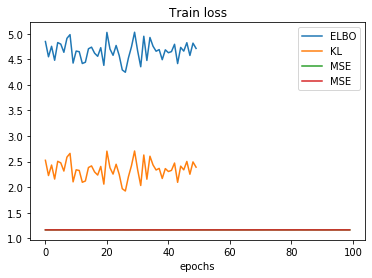

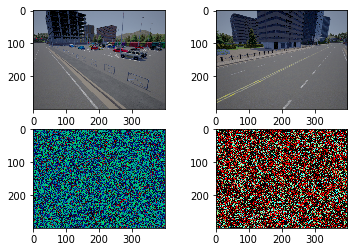

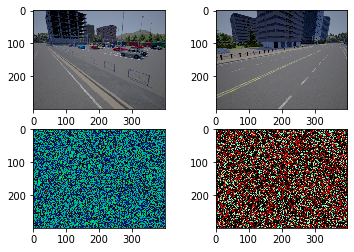

In [10]:
def train(net, optimizer, criterion, epochs):
    model = net
    total_step = 0
    losses = []
    kl_loss = []
    mseX_loss = []
    mseY_loss = []
    for epoch in range(epochs):
        model.train()
        total = 0
        running_loss = 0.0
        kl_running = 0.0
        mseX_running = 0.0
        mseY_running = 0.0

        for i, X in enumerate(dl):
            left_image_t = X[0][:, 0, :, :, :] # left/right images of t
            right_image_t = X[0][:, 1, :, :, :] # left/right images of t

            # img2 = X[1] # left/right of t+1 # xcxc do the same indexing above to get l/r of t+1
            ctrl_inputs = X[2]
            left_image_t = (left_image_t/255).float()
            right_image_t = (right_image_t/255).float()

            left_image_t.to(device)
            right_image_t.to(device)
            ctrl_inputs.to(device)

            xhat, yhat, z, z_mean, z_logvar = model.forward(left_image_t,right_image_t,ctrl_inputs)
            loss, MSE_X, MSE_Y, KLD = criterion(xhat,left_image_t, yhat, right_image_t, z_mean, z_logvar)
            optimizer.zero_grad()
            loss.backward()
            total_step += 1

            running_loss += loss.item()
            kl_running += KLD.item()
            mseX_running += MSE_X.item()
            mseY_running += MSE_Y.item()
            total += ctrl_inputs.size(0)
            if i == 5:
                break

            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, total_step, loss.item()))

        losses.append(running_loss/total)     
        kl_loss.append(kl_running/total)
        mseX_loss.append(mseX_running/total)
        mseX_loss.append(mseX_running/total)  

    left = []
    right = []
    recon_left = []
    recon_right = []
    for i, X in enumerate(dl):
        model.eval()
        left_image_t = (X[0][:, 0, :, :, :]/255).float() # left/right images of t
        right_image_t = (X[0][:, 1, :, :, :]/255).float() # left/right images of t
        ctrl_inputs = X[2]

        left_image_t.to(device)
        right_image_t.to(device)
        ctrl_inputs.to(device)

        #Forward Pass
        xhat, yhat, z, z_mean, z_stdev = model.forward(left_image_t,right_image_t,ctrl_inputs)

        left_ = _rearrange_channel_last(left_image_t)
        right_ = _rearrange_channel_last(right_image_t)
        xhat_ = _rearrange_channel_last(xhat.cpu().detach().numpy())
        yhat_ = _rearrange_channel_last(yhat.cpu().detach().numpy())
        left.append(left_)
        right.append(right_)
        recon_left.append(xhat_)
        recon_right.append(yhat_)
        if i == 5:
            break
    left = np.asarray(left)
    right = np.asarray(right)
    recon_left = np.asarray(recon_left)
    recon_right = np.asarray(recon_right)

    plt.plot(losses, label='ELBO')
    plt.plot(kl_loss, label='KL')
    plt.plot(mseX_loss, label='MSE')
    plt.plot(mseX_loss, label='MSE')
    plt.title('Train loss')
    plt.xlabel('epochs')
    plt.legend()

    plt.figure()
    plt.subplot(221)
    plt.imshow(left[0,:,:,:])
    plt.subplot(222)
    plt.imshow(right[0,:,:,:])
    plt.subplot(223)
    plt.imshow(recon_left[0,:,:,:])
    plt.subplot(224)
    plt.imshow(recon_right[0,:,:,:])
    plt.figure()
    plt.subplot(221)
    plt.imshow(left[1,:,:,:])
    plt.subplot(222)
    plt.imshow(right[1,:,:,:])
    plt.subplot(223)
    plt.imshow(recon_left[1,:,:,:])
    plt.subplot(224)
    plt.imshow(recon_right[1,:,:,:])


#Run from here
model = siameseCVAE()
epochs = 50
criterion = ELBO_loss
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-3)

train(model, optimizer, criterion, epochs)